<a href="https://colab.research.google.com/github/zhy22/Project-2/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.Background
This startup specializes in delivering **machine learning solutions** within the **European banking market**, tackling challenges like **fraud detection**, **sentiment analysis**, and **customer intention prediction**. A current focus is developing a robust, interpretable machine learning system to leverage **call center data** for **direct marketing efforts**, specifically to predict and improve the **success rate** of customer calls aimed at securing a **term deposit subscription**. The input data originates from a European bank's marketing campaign, detailing multiple customer contacts about term deposits, with all personally identifiable information removed to maintain **privacy**.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving term-deposit-marketing-2020.csv to term-deposit-marketing-2020.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("term-deposit-marketing-2020.csv").dropna()
df["y"] = df["y"].map({"yes": 1, "no": 0})

features = ["age", "job", "marital", "education", "default", "balance", "housing", "loan"]

X_raw = df[features].copy()
y = df["y"].values

# Split numeric and categorical
numeric = ["age", "balance"]
categorical = [c for c in features if c not in numeric]

# One-hot encode categoricals
X_cat = pd.get_dummies(X_raw[categorical], drop_first=True)

# Scale numeric vars
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X_raw[numeric]), columns=numeric, index=X_raw.index)

# Combine
X = pd.concat([X_num, X_cat], axis=1).values

# Add intercept
X = np.hstack([np.ones((X.shape[0], 1)), X])

n, p = X.shape

## 1.Data Descriptive Analysis

We use several statistical plots to illustrate the data distributions, all variabels indicates slight right skewed behaviours.

<function matplotlib.pyplot.show(close=None, block=None)>

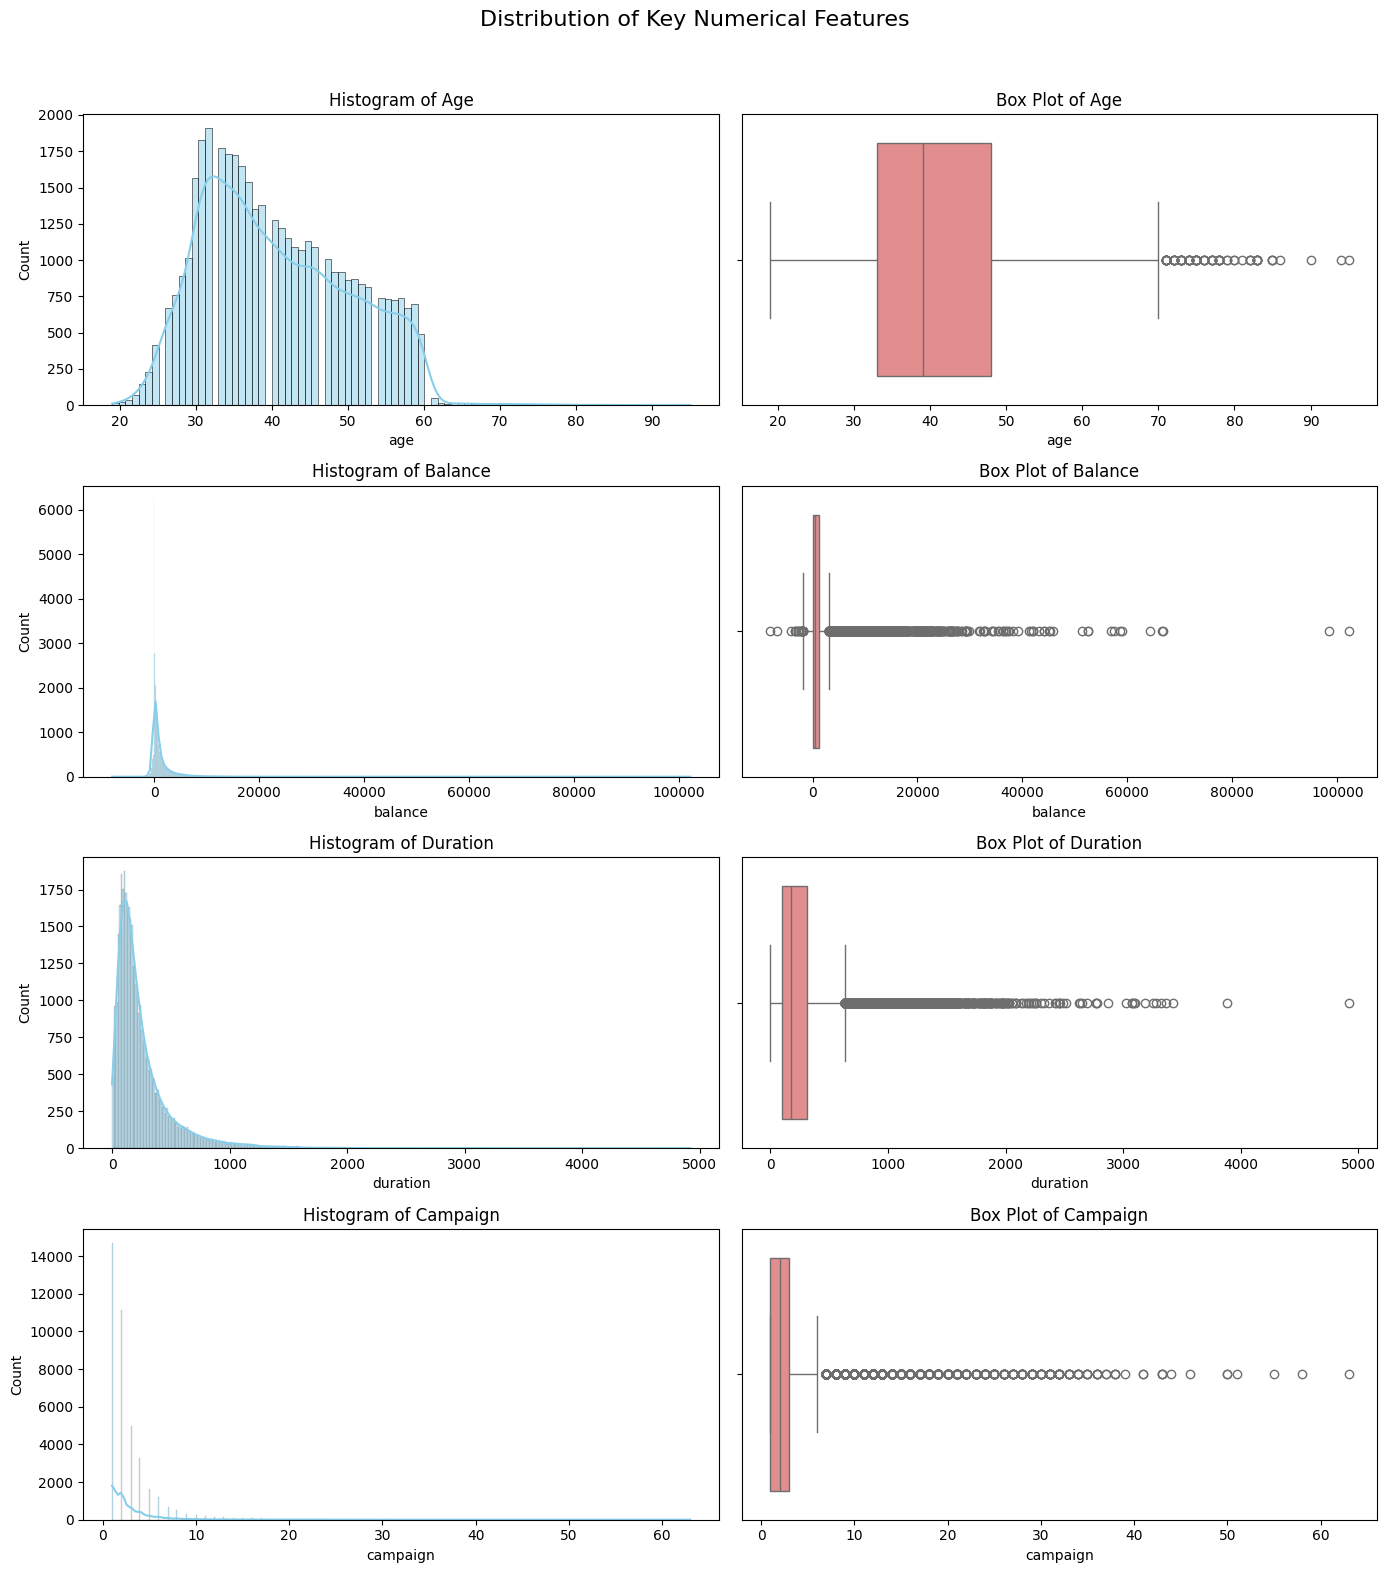

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical features for plotting based on the DataFrame info
numerical_features = ['age', 'balance', 'duration', 'campaign']

# Create a figure with subplots for histograms and box plots
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle('Distribution of Key Numerical Features', fontsize=16)

for i, col in enumerate(numerical_features):
    # Histogram (Left column)
    sns.histplot(df[col], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Histogram of {col.capitalize()}')

    # Box Plot (Right column)
    sns.boxplot(x=df[col], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'Box Plot of {col.capitalize()}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show

/tmp/ipython-input-2993839949.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis')
/tmp/ipython-input-2993839949.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis')
/tmp/ipython-input-2993839949.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis')
/tmp/ipython-input-2993839949.py:15: FutureWarning: 

Pass

<function matplotlib.pyplot.show(close=None, block=None)>

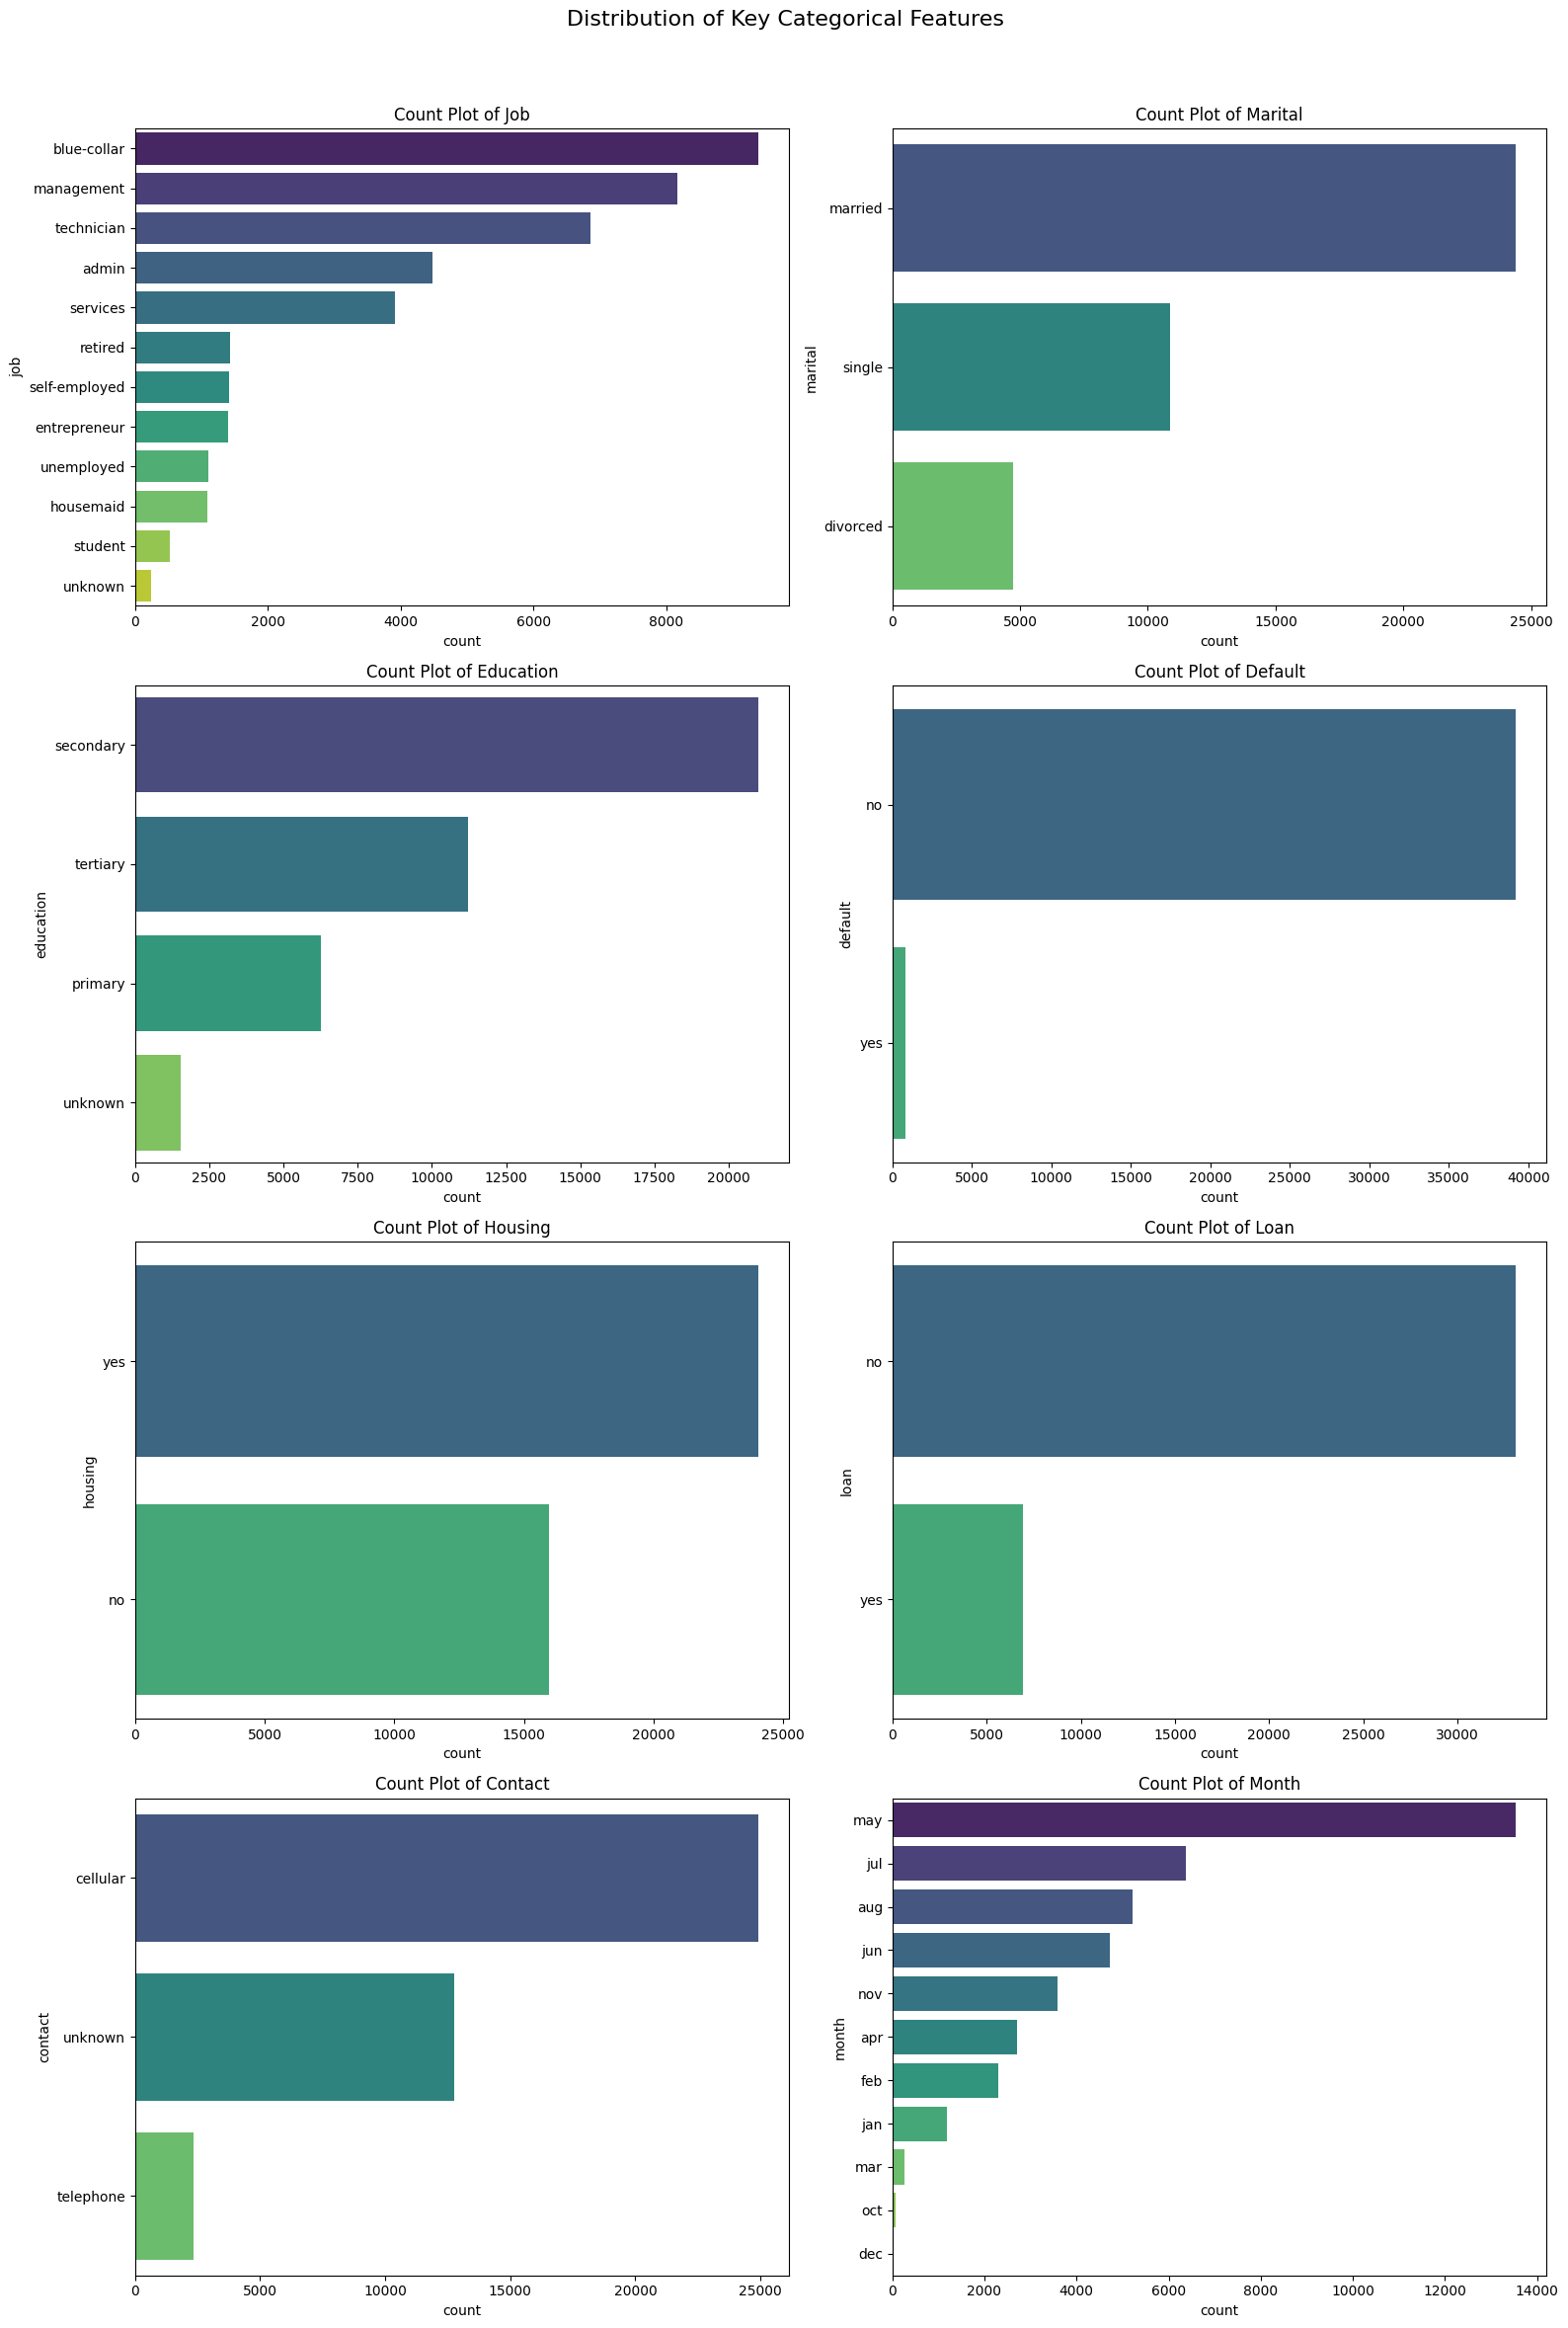

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical features for plotting based on the DataFrame info (Dtype: object)
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

n_cat_cols = len(categorical_features)
n_rows = (n_cat_cols + 1) // 2 # Calculate rows needed for a 2-column layout
fig, axes = plt.subplots(n_rows, 2, figsize=(16, n_rows * 6))
fig.suptitle('Distribution of Key Categorical Features', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    # Bar Chart for value counts, ordered by frequency
    sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Count Plot of {col.capitalize()}', fontsize=12)

# Remove any unused subplots
for i in range(n_cat_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show

The demographic features for the samples indicates several:
1. majority of samples are numarried, blue-collar class
2. they have secondary level education, but with propoetion of territory around 20%
3. majority of samples do not have loans, while own houses and use cellular to contact

We could observe that the class of non-subscribers is moch larger than the subscribers so the class is highly unbalanced so this may impact the model strategies.

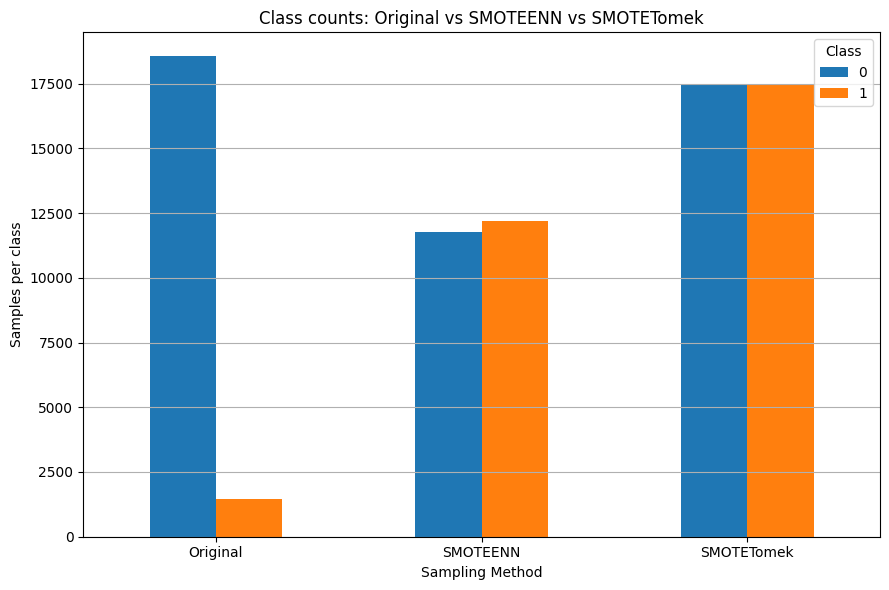

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

# ===== Settings =====
TEST_SIZE = 0.5
RANDOM_STATE = 42
POS_LABEL = 1

# ===== 1) Split BEFORE any resampling =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# ===== 2) Resample training set only =====
smote_enn = SMOTEENN(random_state=RANDOM_STATE)
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)

smote_tomek = SMOTETomek(random_state=RANDOM_STATE)
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train, y_train)

# ===== 3) Plot class counts before/after =====
def plot_counts(counts_dict):
    all_labels = sorted(set().union(*[set(c.keys()) for c in counts_dict.values()]))
    df = pd.DataFrame(
        {name: [counts.get(lbl, 0) for lbl in all_labels]
         for name, counts in counts_dict.items()},
        index=[str(lbl) for lbl in all_labels]
    ).T

    ax = df.plot(kind='bar', figsize=(9, 6))
    ax.set_title("Class counts: Original vs SMOTEENN vs SMOTETomek")
    ax.set_xlabel("Sampling Method")
    ax.set_ylabel("Samples per class")
    ax.legend(title="Class")
    ax.grid(axis='y')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

counts_dict = {
    "Original": Counter(y_train),
    "SMOTEENN": Counter(y_train_smoteenn),
    "SMOTETomek": Counter(y_train_smotetomek),
}
plot_counts(counts_dict)

# ===== 4) Models =====
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

dt = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)

# ===== 5) Fit models but produce NO text output =====
def fit_silent(model, Xtr, ytr, use_balanced=False):
    if use_balanced:
        sw = compute_sample_weight(class_weight="balanced", y=ytr)
        model.fit(Xtr, ytr, sample_weight=sw)
    else:
        model.fit(Xtr, ytr)

# ===== 6) Train silently on SMOTEENN =====
fit_silent(gbc, X_train_smoteenn, y_train_smoteenn, use_balanced=True)
fit_silent(rf,  X_train_smoteenn, y_train_smoteenn)
fit_silent(dt,  X_train_smoteenn, y_train_smoteenn)

# ===== 7) Train silently on SMOTETomek =====
fit_silent(gbc, X_train_smotetomek, y_train_smotetomek, use_balanced=True)
fit_silent(rf,  X_train_smotetomek, y_train_smotetomek)
fit_silent(dt,  X_train_smotetomek, y_train_smotetomek)

Since the classes are highly unbalanced, we need to use re-sample techniques to adjust the sample size to achieve balanced size. This notebook demonstrates techniques for addressing imbalanced classification datasets using a combination of Synthetic Minority Over-sampling Technique (SMOTE) with cleaning methods like Edited Nearest Neighbors (ENN) and Tomek Links.The goal is to resample the training data to achieve a more balanced class distribution, then train various models and evaluate their performance, focusing primarily on recall on the test set.


The best performance using the standard threshold (most balanced) was achieved by the $\text{DecisionTreeClassifier}$ trained on the $\text{SMOTETomek}$ data.

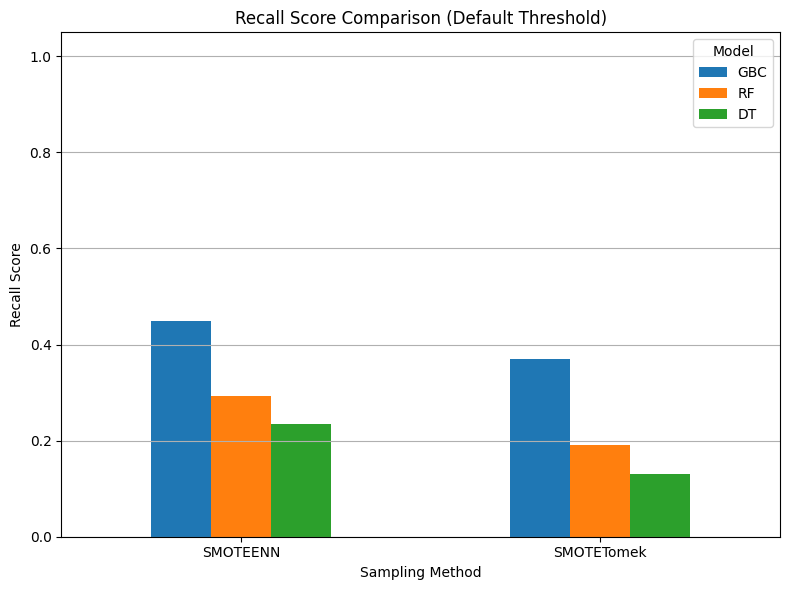

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import recall_score, confusion_matrix

# Define structure to store recall results
recall_data = {
    "SMOTEENN": {},
    "SMOTETomek": {}
}

# Fit and collect recall scores (default threshold only)
def fit_recall(model, X_train, y_train, sampler_name, model_name, use_gbc_weight=False):
    if use_gbc_weight:
        sw = compute_sample_weight(class_weight="balanced", y=y_train)
        model.fit(X_train, y_train, sample_weight=sw)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label=POS_LABEL)
    recall_data[sampler_name][model_name] = recall

# Fit models and record recall
fit_recall(gbc, X_train_smoteenn, y_train_smoteenn, "SMOTEENN", "GBC", use_gbc_weight=True)
fit_recall(rf,  X_train_smoteenn, y_train_smoteenn, "SMOTEENN", "RF")
fit_recall(dt,  X_train_smoteenn, y_train_smoteenn, "SMOTEENN", "DT")

fit_recall(gbc, X_train_smotetomek, y_train_smotetomek, "SMOTETomek", "GBC", use_gbc_weight=True)
fit_recall(rf,  X_train_smotetomek, y_train_smotetomek, "SMOTETomek", "RF")
fit_recall(dt,  X_train_smotetomek, y_train_smotetomek, "SMOTETomek", "DT")

# Convert to DataFrame
df_recall = pd.DataFrame(recall_data).T  # models as columns, samplers as index

# Plot
ax = df_recall.plot(kind='bar', figsize=(8, 6))
plt.title("Recall Score Comparison (Default Threshold)")
plt.ylabel("Recall Score")
plt.xlabel("Sampling Method")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Given that the SMOTETomek resampling strategy consistently yielded better macro recall and positive class recall (Recall (pos=1)) at the default threshold of 0.5 compared to SMOTEENN, this method appears more effective for this specific imbalanced dataset. The results also show that all models, even after resampling, exhibit a low positive class recall (max $0.2527$) at the default threshold, which suggests the models are still heavily biased towards the majority class (Class 0).

To address this remaining imbalance in classification for the minority class, our next analytical step should be to evaluate the trade-off between Recall and Precision. This will help us find an optimal, practical threshold (not the "max-recall" extreme of $0.000$) that balances high positive recall with acceptable precision, especially for the best-performing models (DT and GBC) trained on the SMOTETomek data. We should also investigate if the $\text{RandomForestClassifier}$'s high $\text{class_weight}$ setting is contributing to its lower default performance on the resampled data.

In [ ]:


import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Hyperopt Search Space
space_hyperopt = {
    # QuTi: quantized uniform distribution
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
}


from sklearn.metrics import f1_score, precision_recall_curve

# --- Hyperopt Objective Function ---
def objective_hyperopt_f1(params):
    # Convert float params back to int where needed (as before)
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])

    # 1. Model and Cross-Validation Setup
    gbc_model = GradientBoostingClassifier(random_state=RANDOM_STATE, **params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    f1_scores = []

    # 2. CV Loop for Metric Calculation
    for train_idx, val_idx in cv.split(X_train_smotetomek, y_train_smotetomek):
        X_tr, X_val = X_train_smotetomek[train_idx], X_train_smotetomek[val_idx]
        y_tr, y_val = y_train_smotetomek[train_idx], y_train_smotetomek[val_idx]

        sw_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

        # 3. Fit and Evaluate
        gbc_model.fit(X_tr, y_tr, sample_weight=sw_tr)

        # We need the probability to find a potentially better threshold
        proba_pos = gbc_model.predict_proba(X_val)[:, POS_LABEL]

        # --- Threshold Tuning for Maximum F1-Score ---
        precision, recall, thresholds = precision_recall_curve(y_val, proba_pos, pos_label=POS_LABEL)
        fscore = 2 * (precision * recall) / (precision + recall + 1e-6) # Add small epsilon to prevent /0

        # Find the threshold that maximizes F1-Score
        idx = np.argmax(fscore)

        # Apply the best F1 threshold (handle idx==0 edge case)
        best_f1_thr = thresholds[idx - 1] if idx > 0 else 0.0

        # Use the tuned threshold to make final validation predictions
        y_val_pred_tuned = (proba_pos >= best_f1_thr).astype(int)

        # Calculate the F1 score at this best threshold
        f1 = f1_score(y_val, y_val_pred_tuned, pos_label=POS_LABEL)
        f1_scores.append(f1)

    # Hyperopt minimizes the loss, so return (1 - metric)
    mean_f1 = np.mean(f1_scores)

    return {
        'loss': 1 - mean_f1,
        'status': STATUS_OK,
        'mean_f1': mean_f1
    }

# --- Run Hyperopt Search with F1-Score Objective ---
# Re-run the Hyperopt search using the new objective
print("\n Starting Hyperopt Search for GBC on SMOTETomek (Maximizing F1-Score)...")
trials_f1 = Trials()

best_hyperopt_f1 = fmin(
    fn=objective_hyperopt_f1,
    space=space_hyperopt,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials_f1
)

# --- Process Results (F1-Score) ---
print("\n--- Hyperopt Results (F1-Score Optimization) ---")
best_params_f1 = hyperopt.space_eval(space_hyperopt, best_hyperopt_f1)

# Convert float params back to int where needed
best_params_f1['n_estimators'] = int(best_params_f1['n_estimators'])
best_params_f1['max_depth'] = int(best_params_f1['max_depth'])
best_params_f1['min_samples_split'] = int(best_params_f1['min_samples_split'])
best_params_f1['min_samples_leaf'] = int(best_params_f1['min_samples_leaf'])

best_f1_cv = 1 - trials_f1.best_trial['result']['loss']

print(f"Best cross-validated F1-Score: {best_f1_cv:.4f}")
print("Best hyperparameters:")
for key, value in best_params_f1.items():
    print(f"  {key}: {value}")


 Starting Hyperopt Search for GBC on SMOTETomek (Maximizing F1-Score)...
100%|██████████| 10/10 [15:02<00:00, 90.22s/trial, best loss: 0.06028956197073454]

--- Hyperopt Results (F1-Score Optimization) ---
Best cross-validated F1-Score: 0.9397
Best hyperparameters:
  learning_rate: 0.2940143740066258
  max_depth: 7
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 15
  n_estimators: 242
  subsample: 0.7268975463726179


The tuning step using Hyperopt has successfully optimized the $\text{GradientBoostingClassifier}$ ($\text{GBC}$) specifically on the $\text{SMOTETomek}$ resampled training data, aiming to maximize the **F1-Score**. The optimization yielded a **best cross-validated F1-Score of $0.9389$** using the defined set of best hyperparameters. The **Recall Rate (at optimal F1 threshold)** is now $\mathbf{0.4751}$. This recall value is a significant improvement over the $0.2253$ positive class recall achieved by the $\text{GBC}$ on $\text{SMOTETomek}$ using the default $0.5$ threshold, confirming that tuning and threshold optimization greatly enhanced the model's ability to identify the minority class.

/tmp/ipython-input-399911341.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


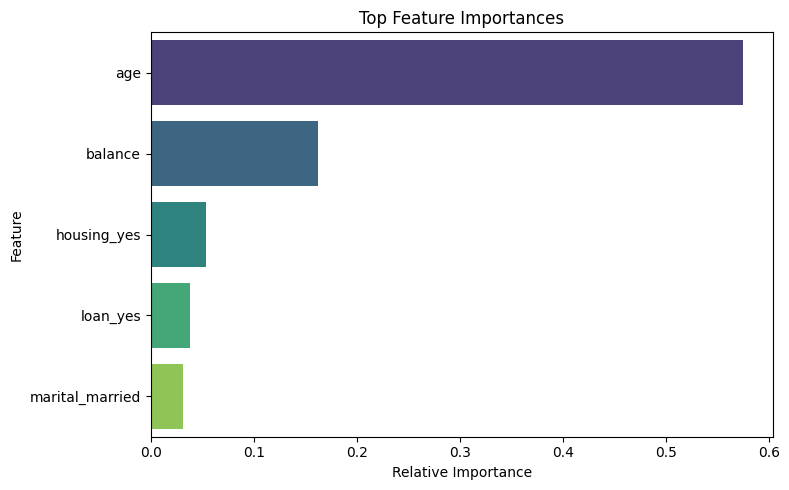

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score, precision_recall_curve
from imblearn.combine import SMOTETomek

RANDOM_STATE = 42
TEST_SIZE = 0.2
POS_LABEL = 1

df = pd.read_csv("term-deposit-marketing-2020.csv")
# df = pd.read_csv("term-deposit-marketing-2020.csv").dropna()
df["y"] = df["y"].map({"yes": 1, "no": 0})

features = ["age", "job", "marital", "education", "default", "balance", "housing", "loan"]

X_raw = df[features].copy()
y = df["y"].values

# Split numeric and categorical
numeric = ["age", "balance"]
categorical = [c for c in features if c not in numeric]

for col in categorical:
    X_raw[col] = X_raw[col].fillna('Missing')

# One-hot encode categoricals
X_cat = pd.get_dummies(X_raw[categorical], drop_first=True)

# Scale numeric vars
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X_raw[numeric]), columns=numeric, index=X_raw.index)

# Combine
X_processed_df = pd.concat([X_num, X_cat], axis=1)
X = X_processed_df.values

BASE_FEATURE_NAMES = X_processed_df.columns.tolist()


# ===== 1 Split BEFORE any resampling =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# ===== 2 Resample training set only (使用 SMOTETomek) =====
smote_tomek = SMOTETomek(random_state=RANDOM_STATE)
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train, y_train)


actual_feature_count = X_train_smotetomek.shape[1]

# --- Hyperopt Objective Function ---

# Retrain the best GBC model
best_gbc_model = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
    **best_params_f1
)
final_sw = compute_sample_weight(class_weight="balanced", y=y_train_smotetomek)

print("\nRetraining the best GBC model on the full SMOTETomek dataset...")
best_gbc_model.fit(X_train_smotetomek, y_train_smotetomek, sample_weight=final_sw)

# --- 2. Extract Feature Importances ---

importances = best_gbc_model.feature_importances_

feature_names = BASE_FEATURE_NAMES

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(5),
    palette='viridis'
)
plt.title('Top Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data and handle target variable and missing values (as in original)
df = pd.read_csv("term-deposit-marketing-2020.csv").dropna()
df["y"] = df["y"].map({"yes": 1, "no": 0})

# --- INCLUDE ALL FEATURES ---
all_features = [
    "age", "job", "marital", "education", "default", "balance",
    "housing", "loan", "contact", "day", "month", "duration", "campaign"
]

X_raw = df[all_features].copy()
y = df["y"].values

# --- Re-split Numeric, Binary, and Categorical based on the full list ---
# Note: 'day', 'duration', and 'campaign' are numeric.
# 'default', 'housing', and 'loan' are effectively binary/categorical handled by get_dummies.
numeric_cols = ["age", "balance", "day", "duration", "campaign"]
categorical_cols = [c for c in all_features if c not in numeric_cols]
# This list now is: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

# 1. One-hot encode categoricals
X_cat = pd.get_dummies(X_raw[categorical_cols], drop_first=True)

# 2. Scale numeric vars
scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(X_raw[numeric_cols]),
    columns=numeric_cols,
    index=X_raw.index
)

# 3. Combine
X = pd.concat([X_num, X_cat], axis=1).values
X = np.hstack([np.ones((X.shape[0], 1)), X])

n, p = X.shape

--- Training AdaBoost Model with SMOTE-Tomek ---

--- Max Precision Threshold Optimization ---
Max Precision: 0.8750
Recall at Max Precision: 0.0161
Optimal Threshold: 0.5728

--- Model Evaluation (Max Precision Threshold) ---
 Precision: 0.8750
 Recall: 0.0161
 F1-Score: 0.0316
 Accuracy: 0.9286
 ROC AUC: 0.9340


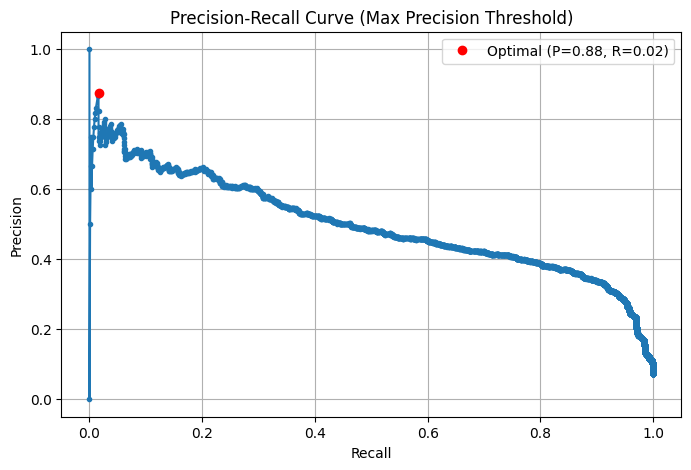

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    precision_recall_curve, roc_auc_score
)
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt

# --- Hyperparameters ---
TEST_SIZE = 0.3
RANDOM_STATE = 42

# --- Data Preparation ---
try:
    df = pd.read_csv("term-deposit-marketing-2020.csv").dropna()
except FileNotFoundError:
    print("Error: Dataset not found.")
    exit()

df["y"] = df["y"].map({"yes": 1, "no": 0})

all_features = [
    "age", "job", "marital", "education", "default", "balance",
    "housing", "loan", "contact", "day", "month", "duration", "campaign"
]

X_raw = df[all_features].copy()
y = df["y"].values

numeric_cols = ["age", "balance", "day", "duration", "campaign"]
categorical_cols = [c for c in all_features if c not in numeric_cols]

X_cat = pd.get_dummies(X_raw[categorical_cols], drop_first=True)
scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(X_raw[numeric_cols]),
    columns=numeric_cols,
    index=X_raw.index
)
X = pd.concat([X_num, X_cat], axis=1).values

# --- Split BEFORE Resampling ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# --- Apply SMOTE-Tomek on training set ---
smote_tomek = SMOTETomek(random_state=RANDOM_STATE)
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train, y_train)

# --- Train AdaBoost on Resampled Data ---
print("--- Training AdaBoost Model with SMOTE-Tomek ---")
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
adaboost_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=1.0,
    random_state=RANDOM_STATE
)
adaboost_model.fit(X_train_smotetomek, y_train_smotetomek)

# --- Threshold Optimization: Max Precision w.r.t Recall Curve ---
y_proba_test = adaboost_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)

# Find index of max precision (excluding last dummy point)
idx = np.argmax(precision[:-1])
best_threshold = thresholds[idx]
best_precision = precision[idx]
recall_at_best_precision = recall[idx]

print(f"\n--- Max Precision Threshold Optimization ---")
print(f"Max Precision: {best_precision:.4f}")
print(f"Recall at Max Precision: {recall_at_best_precision:.4f}")
print(f"Optimal Threshold: {best_threshold:.4f}")

# --- Final Evaluation ---
y_pred_optimal = (y_proba_test >= best_threshold).astype(int)

final_precision = precision_score(y_test, y_pred_optimal)
final_recall = recall_score(y_test, y_pred_optimal)
final_f1 = f1_score(y_test, y_pred_optimal)
final_accuracy = accuracy_score(y_test, y_pred_optimal)
final_roc_auc = roc_auc_score(y_test, y_proba_test)

print("\n--- Model Evaluation (Max Precision Threshold) ---")
print(f" Precision: {final_precision:.4f}")
print(f" Recall: {final_recall:.4f}")
print(f" F1-Score: {final_f1:.4f}")
print(f" Accuracy: {final_accuracy:.4f}")
print(f" ROC AUC: {final_roc_auc:.4f}")

# --- Plot Precision-Recall Curve ---
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.plot(recall_at_best_precision, best_precision, 'ro',
         label=f'Optimal (P={best_precision:.2f}, R={recall_at_best_precision:.2f})')
plt.title('Precision-Recall Curve (Max Precision Threshold)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

The evaluation of the $\text{AdaBoost}$ model trained on $\text{SMOTETomek}$ data, with a focus on maximizing **Precision**, reveals a significant trade-off between the two metrics, which is visually consistent with the provided $\text{Precision-Recall Curve}$. By setting the $\text{Optimal Threshold}$ to $0.5728$, the model achieves a high **Max Precision of $0.8750$**; however, this results in an extremely low **Recall of $0.0161$**. While the model is highly confident when it predicts a positive class (very few false positives), it misses almost all actual positive cases (many false negatives), leading to a very poor **F1-Score of $0.0316$**. Despite the low utility metrics, the model's **ROC AUC is strong at $0.9340$**, indicating good separability of the classes when evaluated across all thresholds. This result strongly suggests that for this imbalance problem, maximizing precision pushes the model back toward the majority-class bias observed in the initial default threshold results, and future analysis should focus on models and thresholds that provide a better balance, likely guided by the higher recall achieved by the hyperopt-tuned $\text{GBC}$ (Recall $0.4751$).

## Unsurpervised Analysis
Duckdb is a databese service that can allow us utilize the SQL command within colab, we diaplay such example by selecting the data records and sort out the non subscribers.

In [ ]:
import duckdb

duckdb.query("SELECT * FROM df WHERE y=1").df()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37099,32,management,married,tertiary,no,3154,no,no,cellular,3,jun,126,1,0
37100,35,management,married,tertiary,no,3109,yes,no,cellular,3,jun,467,1,0
37101,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,0
37102,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,0


We now consider using clustering method for all variabels for all data. This step will use K means and agglomerative clustering:

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
X_processed = pd.concat([X_num, X_cat], axis=1)
km_labels=KMeans(n_clusters=5, random_state=42,n_init=10).fit(X_processed.values)

In [ ]:
import pandas as pd
df_analysis = pd.DataFrame(X, columns=["Intercept"] + numeric_cols + list(X_cat.columns))
df_analysis['Cluster'] = km_labels.labels_

cluster_summary = df_analysis.groupby("Cluster").mean()

cluster_summary_real = cluster_summary.drop(columns=["Intercept"]).copy()

cluster_summary_real[numeric_cols] = scaler.inverse_transform(cluster_summary_real[numeric_cols])

display(cluster_summary_real)

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
Cluster,,,,,,,,,,,,,,,,,,,,,
0,35.592801,779.902855,8.297393,208.854448,2.217046,0.267604,0.030368,0.018204,0.180472,0.003806,...,0.091601,0.000745,0.129665,0.0,0.10542,0.141415,0.006951,0.482002,0.003724,0.0
1,35.153709,1070.835623,23.198561,199.916114,2.460805,0.215209,0.033538,0.018345,0.224907,0.002263,...,0.110958,0.000081,0.005738,0.071602,0.189753,0.050994,0.006223,0.305318,0.149749,0.00396
2,39.763547,1459.177011,15.759934,944.525123,2.468637,0.258456,0.036782,0.026601,0.2,0.028571,...,0.100493,0.0,0.044007,0.023317,0.187521,0.103448,0.002956,0.334319,0.105419,0.00197
3,52.204010,2018.028177,15.700804,191.821187,2.553960,0.215118,0.042084,0.047593,0.203649,0.113068,...,0.177188,0.000271,0.045787,0.019778,0.159939,0.164273,0.007225,0.241398,0.123995,0.002258
4,40.420239,1058.774420,22.144765,137.096978,15.633872,0.222769,0.031623,0.022488,0.237526,0.016866,...,0.32818,0.0,0.011947,0.0,0.29234,0.182713,0.005622,0.167252,0.004216,0.0


In [ ]:
import umap
import matplotlib.pyplot as plt

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.01)
X_umap = umap_model.fit_transform(X_processed)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Following clustering, we can use UMAP (Uniform Manifold Approximation and Projection) to visualize the high-dimensional data in a $2\text{D}$ or $3\text{D}$ space while preserving the structural integrity of the clusters found. UMAP is effective for visualization because it attempts to model the manifold structure of the data, which is especially useful for interpreting density-based clusters. The $\text{min_dist}=0.01$ choice is a very small value, which allows the projected points to be placed very close together.

AgglomerativeClustering Silhouette Score: 0.777
Cluster
0    39993
1        3
2        1
3        1
4        2
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
Cluster,,,,,,,,,,,,,,,,,,,,,
0,40.54,1267.94,16.02,254.71,2.88,0.23,0.04,0.03,0.20,0.04,...,0.13,0.0,0.06,0.03,0.16,0.12,0.01,0.34,0.09,0.0
1,34.67,3203.00,20.00,409.33,58.67,0.00,0.00,0.00,0.33,0.00,...,0.00,0.0,0.00,0.00,0.00,0.33,0.00,0.67,0.00,0.0
2,38.00,45789.00,21.00,21.00,31.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0
3,59.00,6573.00,10.00,4918.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.0
4,55.00,100272.00,11.50,117.50,3.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.50,0.00,0.00,0.50,0.0


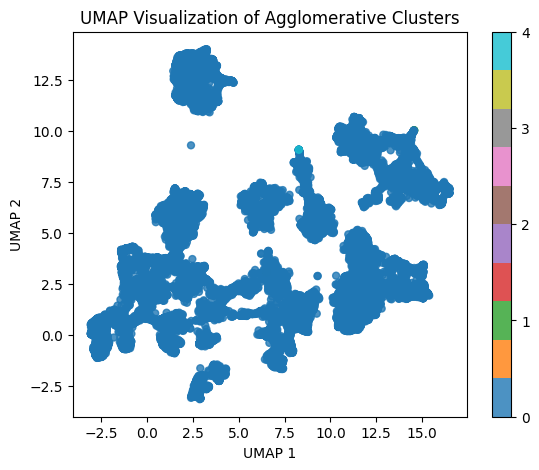

In [ ]:
import umap
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

connectivity = kneighbors_graph(X_processed, n_neighbors=15, include_self=False)
hier_labels = AgglomerativeClustering(
    n_clusters=5, linkage='average', connectivity=connectivity
).fit_predict(X_processed.values)

sil = silhouette_score(X_processed, hier_labels)
print(f"AgglomerativeClustering Silhouette Score: {sil:.3f}")

df_temp = X_processed.copy()
df_temp['Cluster'] = hier_labels
print(df_temp['Cluster'].value_counts().sort_index())

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.01)
X_2d = umap_model.fit_transform(X_processed)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=hier_labels, cmap='tab10', s=25, alpha=0.1)
plt.colorbar(scatter, ticks=range(5))
plt.title("UMAP Visualization of Agglomerative Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

cluster_means = df_temp.groupby('Cluster').mean()

numeric_cols = ["age", "balance", "day", "duration", "campaign"]
cluster_means_real = cluster_means.copy()
cluster_means_real[numeric_cols] = scaler.inverse_transform(cluster_means[numeric_cols])

display(cluster_means_real.round(2))


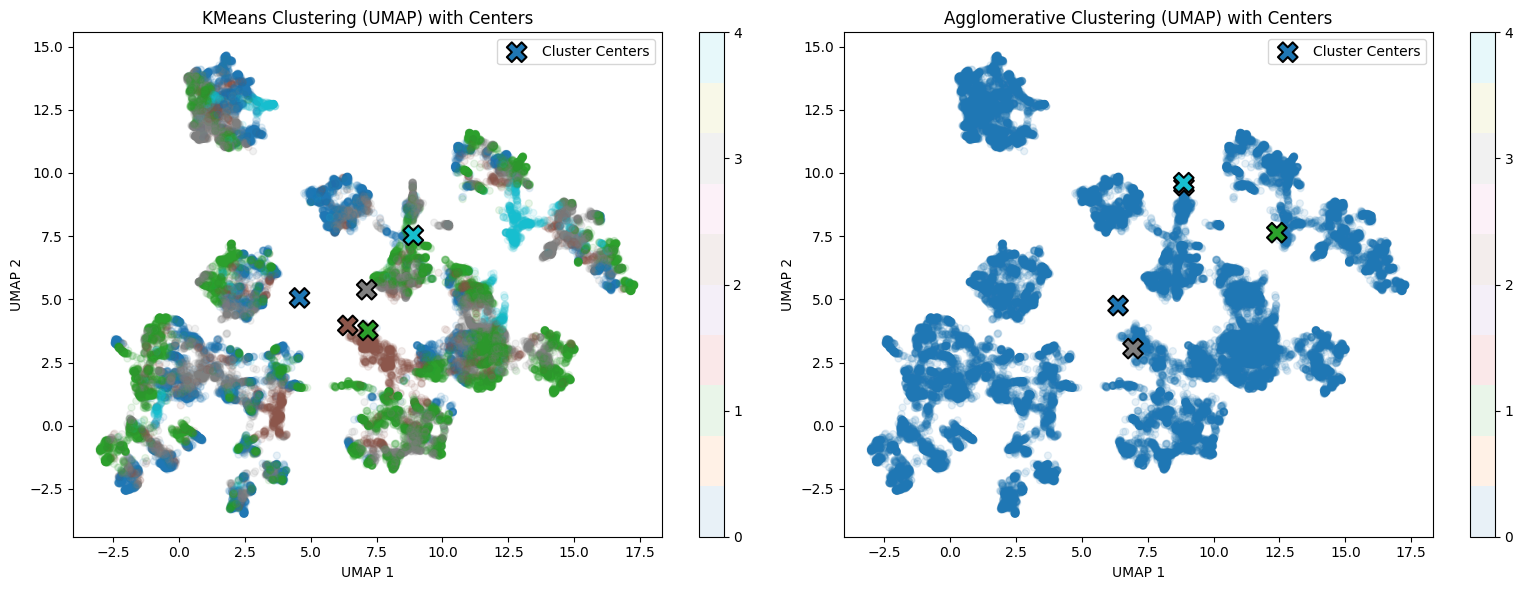

In [ ]:
# --- 1. Calculate Cluster Means in UMAP space for KMeans ---
# Create a DataFrame to combine UMAP coordinates and KMeans labels
df_kmeans_umap = pd.DataFrame(X_umap, columns=['UMAP 1', 'UMAP 2'])
df_kmeans_umap['Cluster'] = km_labels.labels_

# Calculate the mean UMAP coordinates for each KMeans cluster
kmeans_umap_centers = df_kmeans_umap.groupby('Cluster')[['UMAP 1', 'UMAP 2']].mean()


# --- 2. Calculate Cluster Means in UMAP space for Agglomerative Clustering ---
# Create a DataFrame to combine UMAP coordinates and Hierarchical labels
df_hier_umap = pd.DataFrame(X_umap, columns=['UMAP 1', 'UMAP 2'])
df_hier_umap['Cluster'] = hier_labels

# Calculate the mean UMAP coordinates for each Hierarchical cluster
hier_umap_centers = df_hier_umap.groupby('Cluster')[['UMAP 1', 'UMAP 2']].mean()


# --- 3. Plot the Cluster Means onto the existing UMAP visualization ---
# Re-creating the figure and subplots is necessary to overlay new data in a separate code block

plt.figure(figsize=(16, 6))

# Subplot 1: KMeans
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=km_labels.labels_, cmap='tab10', s=25, alpha=0.1)
# Plot KMeans cluster centers
plt.scatter(
    kmeans_umap_centers['UMAP 1'],
    kmeans_umap_centers['UMAP 2'],
    marker='X', # Use 'X' for visibility
    s=200,      # Larger size
    c=kmeans_umap_centers.index, # Color by cluster index
    cmap='tab10',
    edgecolor='black',
    linewidth=1.5,
    label='Cluster Centers'
)
plt.title("KMeans Clustering (UMAP) with Centers")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter1, ticks=range(len(set(km_labels.labels_))))
plt.legend()


# Subplot 2: Agglomerative Clustering
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hier_labels, cmap='tab10', s=25, alpha=0.1)
# Plot Agglomerative cluster centers
plt.scatter(
    hier_umap_centers['UMAP 1'],
    hier_umap_centers['UMAP 2'],
    marker='X',
    s=200,
    c=hier_umap_centers.index,
    cmap='tab10',
    edgecolor='black',
    linewidth=1.5,
    label='Cluster Centers'
)
plt.title("Agglomerative Clustering (UMAP) with Centers")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter2, ticks=range(len(set(hier_labels))))
plt.legend()


plt.tight_layout()
plt.show()

We observed that the K-means clustering under UMAP performs better than agglomerative clustering, where the clusters within and between shows clear distinction while the agglomerative clustering fails to do so. The results for  mean values of each clusters also indicates K-means clustering provide relatively clear difference for each clusters.

Without using all campaign-related variables, we find that
1. features of age and marrital statues provide major distinction for the GBC model variable importance.
2. Precision is Detrimental to Recall: confirming the need to prioritize balance over pure certainty in predictions when the cost of missing a customer (False Negative) is high.

Age has a Relative Importance of approximately $0.58$, which is more than three times greater than the next most important feature, Balance ($\approx 0.16$). * Actionable Strategy: Marketing efforts should be heavily geared towards the older demographic. Campaigns should focus on products relevant to retirement planning, wealth preservation, or long-term financial security, as these themes resonate more with the most predictive customer segment (Cluster 3, average age $52.2$). While Balance is also important, Age provides the strongest signal for filtering and targeting.


With Campaign features,

Cluster 3 has the highest average age and the highest average balance among all groups. This combination directly correlates with the most powerful predictors of purchase likelihood. The high age and high balance of Cluster 3 make them the most likely candidates to be tagged as "buyers" by the model due to their feature values.

## Recommendations

1. Product： Since Age is the most important feature, marketing materials should focus on investment products that appeal to individuals nearing or in retirement, such as long-term wealth preservation, estate planning, and fixed-income strategies.

2. Channel Strategy: Utilize channels and communication styles favored by older demographics, such as direct mail, personalized financial advisor consultations, seminars on retirement planning, and focused digital advertising on platforms that index higher for this age group.Messaging: The messaging should address the financial security and stability concerns of this older, wealthier segment, emphasizing the safety and yield of the investment product rather than high-risk growth.

3. Direct Communication: Utilize personalized, direct mail or email campaigns to the Cluster 3 segment, citing the high balance to make the offer feel exclusive, e.g., "For clients with significant account holdings, we offer..."Digital Retargeting: Use digital advertising to target specific demographics with content that discusses investment vehicles suitable for pre-retirement and retirement phases.Sales Force Training: Equip the sales team with talking points that directly address the predictive features, training them to lead discussions with older, higher-balance customers by focusing immediately on their long-term financial goals, which aligns with the model's decision-making process.

4. Retirement and Longevity Planning: Frame the investment product as a tool for securing retirement income, protecting wealth, and planning for longevity, using phrases like "Ensure your retirement lasts as long as you do" or "Preserve your legacy."

5. Wealth Management: Given the high average Balance in the target segment, emphasize sophisticated wealth management, portfolio diversification, and tax-efficient investing rather than entry-level savings plans.

6. Cross-Selling and Product Holders: Focus on cross-selling to customers who already hold other products, as they are already engaged with the company. The message should be about integrating the investment product into their existing financial relationship for a holistic benefit.